In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import norm, skew 
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_log_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import accuracy_score

In [2]:
df_train=pd.read_csv("Flights_ticket_price_train.csv")
df_train.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR ? DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU ? IXR ? BBI ? BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL ? LKO ? BOM ? COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU ? NAG ? BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR ? NAG ? DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [3]:
df_test=pd.read_csv("Flights_ticket_price_test.csv")
df_test.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL ? BOM ? COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU ? MAA ? BLR,06:20,10:20,4h,1 stop,No info
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL ? BOM ? COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL ? BOM ? COK,08:00,21:00,13h,1 stop,No info
4,Air Asia,24/06/2019,Banglore,Delhi,BLR ? DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info


In [4]:
#Get the Number of Rows and Columns
print('Train_data:',df_train.shape)
print('Test_data:',df_test.shape)

Train_data: (10683, 11)
Test_data: (2671, 10)


In [5]:
#drop null column values
df_train.dropna(inplace=True)

In [6]:
#Check for null values in the dataset
df_train.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64

In [7]:
# Select duplicate rows
duplicateRowsDF = df_train[df_train.duplicated()]
print("Total Duplicate Rows except first occurrence based on all columns are :")
duplicateRowsDF.shape

Total Duplicate Rows except first occurrence based on all columns are :


(220, 11)

In [8]:
df_train.drop_duplicates(keep='first',inplace=True)

Data cleaning

In [9]:
print("Train set:\n",df_train["Additional_Info"].value_counts())
print("Test set:\n",df_test["Additional_Info"].value_counts())

Train set:
 No info                         8182
In-flight meal not included     1926
No check-in baggage included     318
1 Long layover                    19
Change airports                    7
Business class                     4
No Info                            3
2 Long layover                     1
Red-eye flight                     1
1 Short layover                    1
Name: Additional_Info, dtype: int64
Test set:
 No info                         2148
In-flight meal not included      444
No check-in baggage included      76
Change airports                    1
1 Long layover                     1
Business class                     1
Name: Additional_Info, dtype: int64


In [10]:
df_train["Additional_Info"] = df_train["Additional_Info"].replace({'No Info': 'No info'})

In [11]:
df_test["Additional_Info"].value_counts()

No info                         2148
In-flight meal not included      444
No check-in baggage included      76
Change airports                    1
1 Long layover                     1
Business class                     1
Name: Additional_Info, dtype: int64

In [12]:
df_test["Airline"].value_counts()

Jet Airways                          897
IndiGo                               511
Air India                            440
Multiple carriers                    347
SpiceJet                             208
Vistara                              129
Air Asia                              86
GoAir                                 46
Multiple carriers Premium economy      3
Vistara Premium economy                2
Jet Airways Business                   2
Name: Airline, dtype: int64

In [13]:
df_train.Total_Stops.replace(['1 stop', 'non-stop', '2 stops', '3 stops', '4 stops'], [1, 0, 2, 3, 4], inplace=True)
df_test.Total_Stops.replace(['1 stop', 'non-stop', '2 stops', '3 stops', '4 stops'], [1, 0, 2, 3, 4], inplace=True)
df_train["Total_Stops"] = df_train["Total_Stops"].astype(int)
df_test["Total_Stops"] = df_test["Total_Stops"].astype(int)

In [14]:
df_train["isWeekend"] = ((pd.to_datetime(df_train["Date_of_Journey"], format = '%d/%m/%Y').dt.dayofweek) // 5 == 1).astype(int)
df_train["Day_of_Week"] = pd.to_datetime(df_train["Date_of_Journey"], format = '%d/%m/%Y').dt.day_name()
df_train["Day_Of_Journey"] = pd.to_datetime(df_train["Date_of_Journey"], format = '%d/%m/%Y').dt.day
df_train["Month_of_Journey"] = pd.to_datetime(df_train["Date_of_Journey"], format = '%d/%m/%Y').dt.month

df_test["isWeekend"] = ((pd.to_datetime(df_test["Date_of_Journey"], format = '%d/%m/%Y').dt.dayofweek) // 5 == 1).astype(int)
df_test["Day_Of_Journey"] = pd.to_datetime(df_test["Date_of_Journey"], format = '%d/%m/%Y').dt.day
df_test["Day_of_Week"] = pd.to_datetime(df_test["Date_of_Journey"], format = '%d/%m/%Y').dt.day_name()
df_test["Month_of_Journey"] = pd.to_datetime(df_test["Date_of_Journey"], format = '%d/%m/%Y').dt.month

In [15]:
df_train.drop(labels = 'Date_of_Journey', axis = 1, inplace = True)
df_test.drop(labels = 'Date_of_Journey', axis = 1, inplace = True)

In [16]:
# cleaning duration column in train dataset
duration = list(df_train["Duration"])

for i in range(len(duration)) :
    if len(duration[i].split()) != 2:
        if 'h' in duration[i] :
            duration[i] = duration[i].strip() + ' 0m'
        elif 'm' in duration[i] :
            duration[i] = '0h {}'.format(duration[i].strip())

dur_hours = []
dur_minutes = []  
dur_seconds = []
for i in range(len(duration)) :
    dur_minutes.append(int(duration[i].split()[0][:-1])*60 + int(duration[i].split()[1][:-1]))
    dur_seconds.append(int(duration[i].split()[0][:-1])*60*60 + int(duration[i].split()[1][:-1])*60)
df_train["Duration_minutes"] = dur_minutes
df_train.drop(["Duration"], axis=1, inplace = True)

In [17]:
# cleaning duration column in Test dataset
duration = list(df_test["Duration"])

for i in range(len(duration)) :
    if len(duration[i].split()) != 2:
        if 'h' in duration[i] :
            duration[i] = duration[i].strip() + ' 0m'
        elif 'm' in duration[i] :
            duration[i] = '0h {}'.format(duration[i].strip())

dur_hours = []
dur_minutes = []  
dur_seconds = []
for i in range(len(duration)) :
    dur_minutes.append(int(duration[i].split()[0][:-1])*60 + int(duration[i].split()[1][:-1]))
    dur_seconds.append(int(duration[i].split()[0][:-1])*60*60 + int(duration[i].split()[1][:-1])*60)
df_test["Duration_minutes"] = dur_minutes
df_test.drop(labels = 'Duration', axis = 1, inplace = True)

In [18]:
df_train['Depart_Time_Hour'] = pd.to_datetime(df_train.Dep_Time).dt.hour
df_train['Depart_Time_Minutes'] = pd.to_datetime(df_train.Dep_Time).dt.minute
df_train.drop(labels = 'Dep_Time', axis = 1, inplace = True)
df_train['Arr_Time_Hour'] = pd.to_datetime(df_train.Arrival_Time).dt.hour
df_train['Arr_Time_Minutes'] = pd.to_datetime(df_train.Arrival_Time).dt.minute
df_train.drop(labels = 'Arrival_Time', axis = 1, inplace = True)


df_test['Depart_Time_Hour'] = pd.to_datetime(df_test.Dep_Time).dt.hour
df_test['Depart_Time_Minutes'] = pd.to_datetime(df_test.Dep_Time).dt.minute
df_test.drop(labels = 'Dep_Time', axis = 1, inplace = True)
df_test['Arr_Time_Hour'] = pd.to_datetime(df_test.Arrival_Time).dt.hour
df_test['Arr_Time_Minutes'] = pd.to_datetime(df_test.Arrival_Time).dt.minute
df_test.drop(labels = 'Arrival_Time', axis = 1, inplace = True)

# EDA

count    10462.000000
mean      9026.790289
std       4624.849541
min       1759.000000
25%       5224.000000
50%       8266.000000
75%      12344.750000
max      79512.000000
Name: Price, dtype: float64
Skewness: 1.857490
Kurtosis: 13.527896


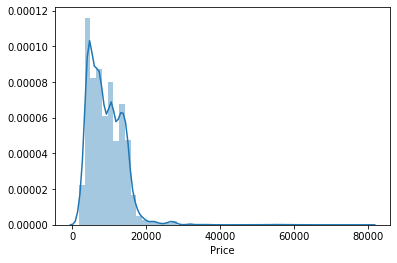

In [19]:
print(df_train['Price'].describe())
print("Skewness: %f" % df_train['Price'].skew())
print("Kurtosis: %f" % df_train['Price'].kurt())
sns.distplot(df_train['Price'])

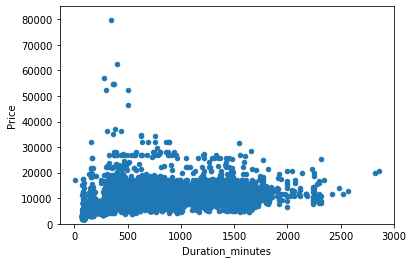

In [20]:
var = 'Duration_minutes'
data = pd.concat([df_train['Price'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='Price', ylim=(0,85000));

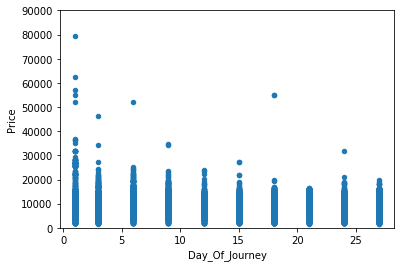

In [21]:
var = 'Day_Of_Journey'
data = pd.concat([df_train['Price'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='Price', ylim=(0,90000));

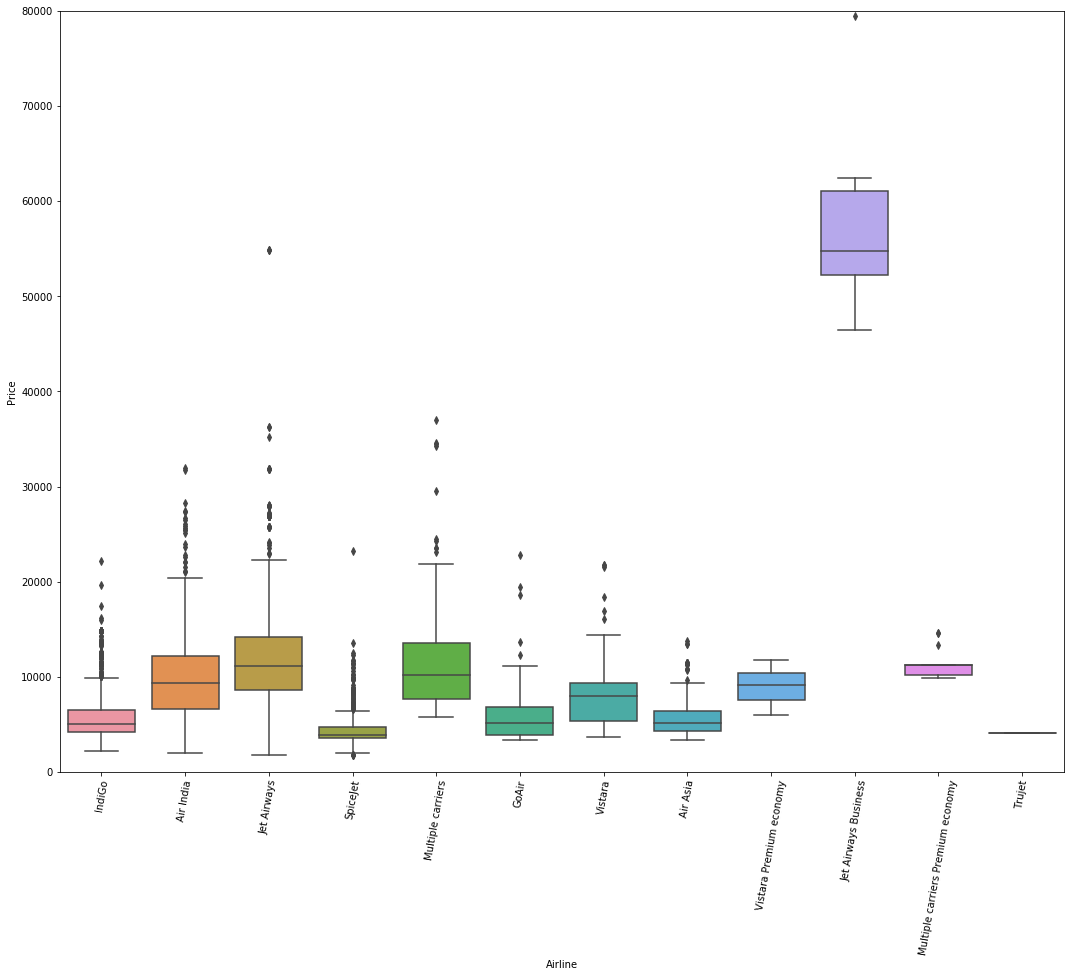

In [22]:
var = 'Airline'
data = pd.concat([df_train['Price'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(18, 14))
fig = sns.boxplot(x=var, y="Price", data=data)
plt.xticks(fontsize=10, rotation=80)
fig.axis(ymin=0, ymax=80000);

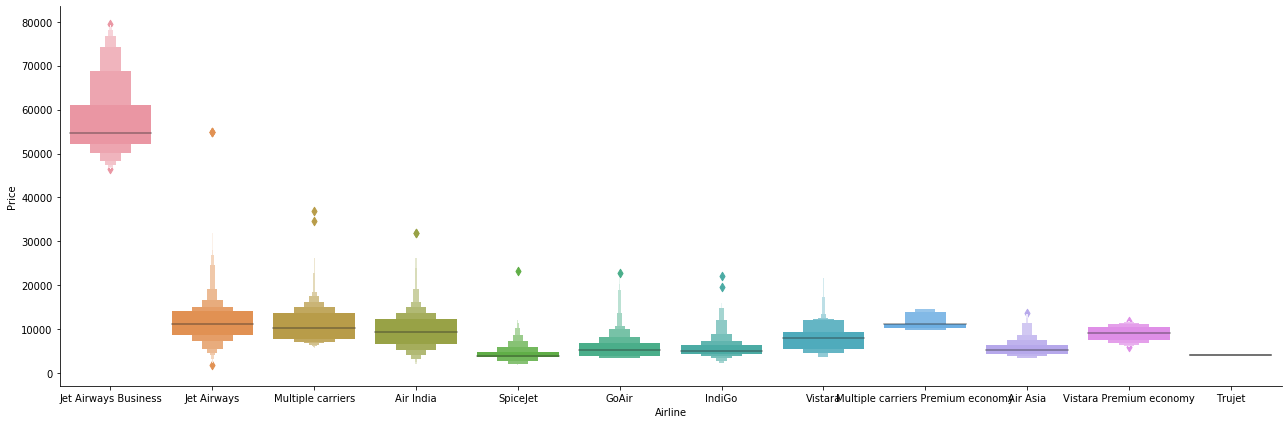

In [23]:
sns.catplot(y = "Price", x = "Airline", data = df_train.sort_values("Price", ascending = False), kind="boxen", height = 6, aspect = 3)
plt.show()


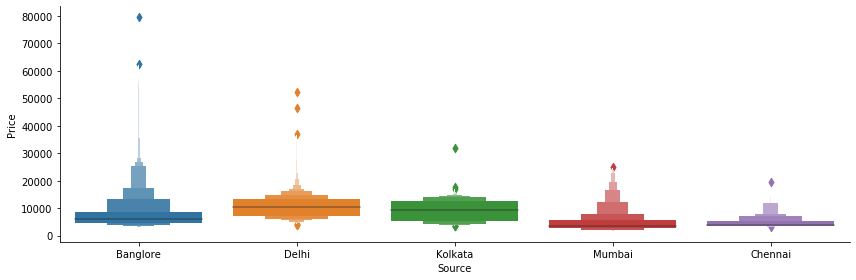

In [24]:
sns.catplot(y = "Price", x = "Source", data = df_train.sort_values("Price", ascending = False), kind="boxen", height = 4, aspect = 3)
plt.show()


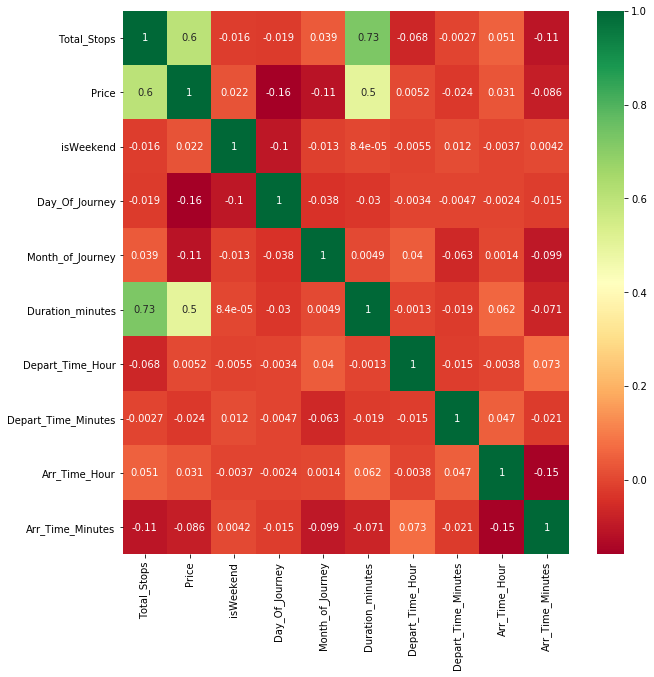

In [25]:
plt.figure(figsize = (10,10))
sns.heatmap(df_train.corr(), annot = True, cmap = "RdYlGn")

plt.show()

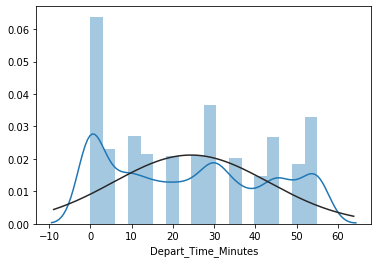

In [26]:
sns.distplot(df_train["Depart_Time_Minutes"] , fit=norm);

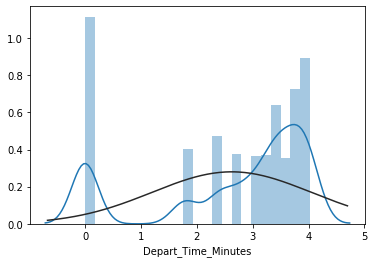

In [27]:
sns.distplot(np.log1p(df_train["Depart_Time_Minutes"]) , fit=norm);

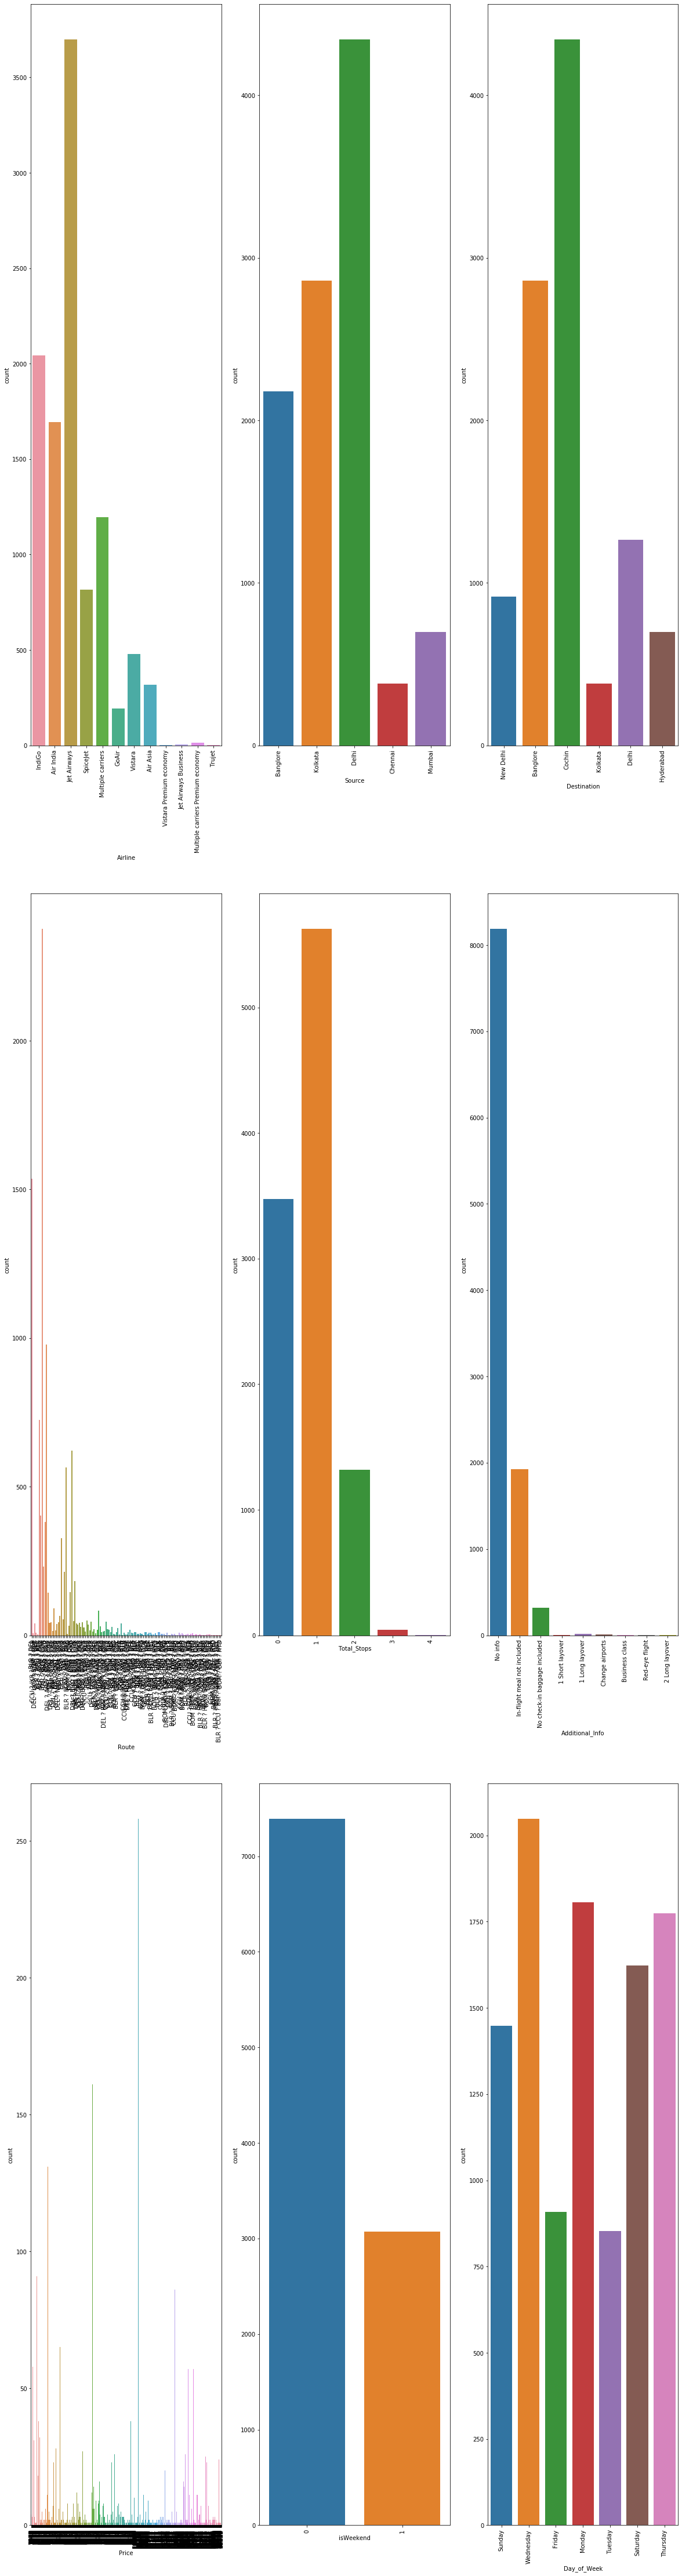

In [28]:
fig, ax = plt.subplots(3, 3, figsize=(20, 80))
columns = df_train.columns.tolist()
for variable, subplot in zip(columns, ax.flatten()):
    sns.countplot(df_train[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

# Data Preprocessing

In [29]:
X = df_train.drop(["Price"], axis=1)
y = np.log1p(df_train["Price"])
x = df_test

In [30]:
#Separate categorical and numerical columns in dataframe
X_categorical = X.select_dtypes(exclude=['int', 'float'])
X_numerical = X.select_dtypes(include=['int', 'float'])

x_categorical = x.select_dtypes(exclude=['int', 'float'])
x_numerical = x.select_dtypes(include=['int', 'float'])

In [31]:
X_categorical.head()

X_numerical_graph = X_numerical.copy()
X_categorical_graph = X_categorical.copy()

In [32]:
X_numerical.head()

,Total_Stops,isWeekend
0,0,1
1,2,0
2,2,1
3,1,1
4,1,0


In [33]:
X_categorical["Airline"].replace(to_replace={'Multiple carriers Premium economy':'Other', 
                                                        'Jet Airways Business':'Other',
                                                        'Vistara Premium economy':'Other',
                                                        'Trujet':'Other'
                                                   },    
                                        inplace=True)

x_categorical["Airline"].replace(to_replace={'Multiple carriers Premium economy':'Other', 
                                                        'Jet Airways Business':'Other',
                                                        'Vistara Premium economy':'Other',
                                                        'Trujet':'Other'
                                                   },    
                                        inplace=True)

In [34]:
X_categorical["Additional_Info"].replace(to_replace={'Change airports':'Other', 
                                                        'Business class':'Other',
                                                        '1 Short layover':'Other',
                                                        'Red-eye flight':'Other',
                                                        '2 Long layover':'Other',   
                                                   },    
                                        inplace=True)
x_categorical["Additional_Info"].replace(to_replace={'Change airports':'Other', 
                                                        'Business class':'Other',
                                                        '1 Short layover':'Other',
                                                        'Red-eye flight':'Other',
                                                        '2 Long layover':'Other',   
                                                   },    
                                        inplace=True)

In [35]:
X_categorical.head()

,Airline,Source,Destination,Route,Additional_Info,Day_of_Week,Day_Of_Journey,Month_of_Journey,Duration_minutes,Depart_Time_Hour,Depart_Time_Minutes,Arr_Time_Hour,Arr_Time_Minutes
0,IndiGo,Banglore,New Delhi,BLR ? DEL,No info,Sunday,24,3,170,22,20,1,10
1,Air India,Kolkata,Banglore,CCU ? IXR ? BBI ? BLR,No info,Wednesday,1,5,445,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL ? LKO ? BOM ? COK,No info,Sunday,9,6,1140,9,25,4,25
3,IndiGo,Kolkata,Banglore,CCU ? NAG ? BLR,No info,Sunday,12,5,325,18,5,23,30
4,IndiGo,Banglore,New Delhi,BLR ? NAG ? DEL,No info,Friday,1,3,285,16,50,21,35


In [36]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
X_categorical = X_categorical.apply(LabelEncoder().fit_transform)
x_categorical = x_categorical.apply(LabelEncoder().fit_transform)

In [37]:
X = pd.concat([X_categorical, X_numerical], axis=1)
x = pd.concat([x_categorical, x_numerical], axis=1)

In [38]:
print(X.shape, X_numerical.shape, X_categorical.shape)
print(x.shape, x_numerical.shape, x_categorical.shape)
print(y.shape)

(10462, 15) (10462, 2) (10462, 13)
(2671, 15) (2671, 2) (2671, 13)
(10462,)


In [39]:
 X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42, test_size=0.3)

In [40]:
def print_accuracy_report(y_test, y_pred,X_test, model):
 print('R Squared(Accuracy)', metrics.r2_score(y_test, y_pred))   
 print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
 print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
 print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
 print('Root Mean Squared Log Error',np.sqrt(mean_squared_log_error( y_test, y_pred )))

In [41]:
lr=LinearRegression()
lr.fit(X_train,y_train)
pred=lr.predict(X_test)
print('MAE:', metrics.mean_absolute_error(y_test, pred))
print('MSE:', metrics.mean_squared_error(y_test, pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, pred)))

MAE: 0.2797969059146258
MSE: 0.11962938573203812
RMSE: 0.34587481222551913


In [42]:
def DecisionTreeRegressorModel(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42, test_size=0.3)
    dt = DecisionTreeRegressor(random_state=42)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    print(print_accuracy_report(y_test, y_pred, X_test, dt))
    return dt
DecisionTreeModel = DecisionTreeRegressorModel(X,y)

R Squared(Accuracy) 0.88262109194461
Mean Absolute Error: 0.08365022734287483
Mean Squared Error: 0.030931458063249692
Root Mean Squared Error: 0.17587341488482475
Root Mean Squared Log Error 0.017431717315310128
None


In [43]:
def KNeighborsRegressorModel(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42, test_size=0.3)
    knn = KNeighborsRegressor(n_neighbors = 5, metric= 'minkowski', p=2)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    print(print_accuracy_report(y_test, y_pred, X_test, knn))
    return knn
KNeighborsModel = KNeighborsRegressorModel(X,y)

R Squared(Accuracy) 0.7512008127242407
Mean Absolute Error: 0.18021515017664896
Mean Squared Error: 0.06556307052847364
Root Mean Squared Error: 0.2560528666671663
Root Mean Squared Log Error 0.025518195911539643
None


In [44]:
def RandomForestRegressorModel(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42, test_size=0.3)
    rf = RandomForestRegressor(random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    print(print_accuracy_report(y_test, y_pred, X_test, rf))
    return rf
randomForestModel = RandomForestRegressorModel(X,y)

R Squared(Accuracy) 0.9326839776540705
Mean Absolute Error: 0.07316353302129455
Mean Squared Error: 0.017738985280007332
Root Mean Squared Error: 0.13318778202225356
Root Mean Squared Log Error 0.013279812032155502
None


In [45]:
def plotFeatureImportances(model):
    feature_importances = pd.DataFrame(model.feature_importances_,
                                   index = X.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
    print(feature_importances)
    features = X.columns.tolist()
    importances = model.feature_importances_
    indices = np.argsort(importances)
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

                     importance
Duration_minutes       0.603715
Airline                0.101580
Day_Of_Journey         0.048639
Month_of_Journey       0.038735
Additional_Info        0.038202
Total_Stops            0.037136
Route                  0.023885
Depart_Time_Minutes    0.017299
Destination            0.016723
Arr_Time_Hour          0.016603
Depart_Time_Hour       0.016324
Day_of_Week            0.015591
Arr_Time_Minutes       0.014026
Source                 0.006018
isWeekend              0.005525


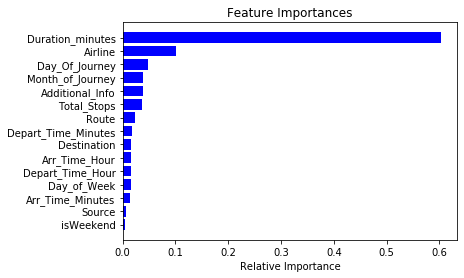

In [46]:
plotFeatureImportances(randomForestModel)

In [47]:
print(lr.intercept_)
print(lr.coef_)

8.756931062099097
[ 3.01376689e-02 -6.83574905e-02 -3.05268710e-02 -4.69041047e-04
  8.24118416e-03 -8.50315803e-03 -2.11556380e-02 -4.92195215e-02
  9.52747527e-04  4.10057656e-03 -6.98776203e-03  2.42829685e-03
 -5.37170134e-03  4.74558901e-01  3.39881105e-02]


In [48]:
y_pred = lr.predict(X_test)
print('Predicted value and actual value',y_pred,y_test)

Predicted value and actual value [9.41419014 8.55950198 8.49044113 ... 9.96833077 8.71887261 9.52813642] 2150    9.797960
3784    8.262043
714     8.403576
7558    7.709308
7413    8.515592
          ...   
4600    9.236300
5310    9.093020
1956    9.608311
2330    8.481359
2311    9.624435
Name: Price, Length: 3139, dtype: float64


In [49]:
from sklearn.externals import joblib
joblib.dump(lr,'Flights_ticket_price_train.obj')

['Flights_ticket_price_train.obj']